# WikiRank

In [536]:
%pip install Wikipedia-API
import requests
from bs4 import BeautifulSoup
import random
from google.colab import drive
import os
from typing import List
import wikipediaapi
import torch
import matplotlib.pyplot as plt
import random
from collections import Counter
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
from ipywidgets import interact, IntSlider
import pickle


In [2]:
drive.mount('/content/drive')

notebooks_dir = '/content/drive/MyDrive/Colab Notebooks'
if os.path.exists(notebooks_dir):
  os.chdir(notebooks_dir)
  print(f"Changed directory to: {os.getcwd()}")
else:
  print(f"Directory not found: {notebooks_dir}")
  print("Please ensure 'Colab Notebooks' exists in your Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Changed directory to: /content/drive/MyDrive/Colab Notebooks


In [3]:
wiki_wiki = wikipediaapi.Wikipedia(user_agent='EigenPageRank (dipasquale.piergiorgio@gmail.com)', language='en')

## possible fields

In [4]:
bio_pages = [
    wiki_wiki.page('Biology'),
    wiki_wiki.page('Cell biology'),
    wiki_wiki.page('Genetics'),
    wiki_wiki.page('Evolution'),
    wiki_wiki.page('Microbiology'),
    wiki_wiki.page('Ecology'),
    wiki_wiki.page('Neuroscience'),
    wiki_wiki.page('Physiology'),
    wiki_wiki.page('Immunology'),
    wiki_wiki.page('Biochemistry'),
    wiki_wiki.page('Molecular biology'),
    wiki_wiki.page('Zoology'),
    wiki_wiki.page('Botany'),
    wiki_wiki.page('Anatomy'),
    wiki_wiki.page('Human biology'),
    wiki_wiki.page('Biotechnology'),
    wiki_wiki.page('Virology'),
    wiki_wiki.page('Parasitology'),
    wiki_wiki.page('Marine biology'),
    wiki_wiki.page('Evolutionary biology')
]

info_pages = [    wiki_wiki.page('Python'),
    wiki_wiki.page('Computer Science'),
    wiki_wiki.page('C++'),
    wiki_wiki.page('Machine Learning'),
    wiki_wiki.page('Algorithm'),
    wiki_wiki.page('Data Structure'),
    wiki_wiki.page('Software Engineering'),
    wiki_wiki.page('Artificial Intelligence'),
    wiki_wiki.page('Programmin Languages'),
    wiki_wiki.page('Statistics'),
    wiki_wiki.page('Computer Programming'),
    wiki_wiki.page('Theory of Computation'),
    wiki_wiki.page('Database'),
    wiki_wiki.page('Operating System'),
    wiki_wiki.page('Compiler'),
    wiki_wiki.page('Information Theory'),
    wiki_wiki.page('Numerical Analysis'),
    wiki_wiki.page('Cybersecurity'),
    wiki_wiki.page('Parallel Computing'),
    wiki_wiki.page('Quantum Computing')
]
history_pages = [
    wiki_wiki.page('History'),
    wiki_wiki.page('Ancient history'),
    wiki_wiki.page('Middle Ages'),
    wiki_wiki.page('Renaissance'),
    wiki_wiki.page('Industrial Revolution'),
    wiki_wiki.page('World War I'),
    wiki_wiki.page('World War II'),
    wiki_wiki.page('Cold War'),
    wiki_wiki.page('American Revolution'),
    wiki_wiki.page('French Revolution'),
    wiki_wiki.page('Roman Empire'),
    wiki_wiki.page('Ancient Greece'),
    wiki_wiki.page('Medieval Europe'),
    wiki_wiki.page('Chinese history'),
    wiki_wiki.page('Japanese history'),
    wiki_wiki.page('Indian history'),
    wiki_wiki.page('African history'),
    wiki_wiki.page('Islamic Golden Age'),
    wiki_wiki.page('Colonialism'),
    wiki_wiki.page('History of science')
]

sports_pages = [
    wiki_wiki.page('Sports'),
    wiki_wiki.page('Football (soccer)'),
    wiki_wiki.page('Basketball'),
    wiki_wiki.page('Baseball'),
    wiki_wiki.page('Tennis'),
    wiki_wiki.page('Cricket'),
    wiki_wiki.page('Rugby football'),
    wiki_wiki.page('Athletics (track and field)'),
    wiki_wiki.page('Olympic Games'),
    wiki_wiki.page('FIFA World Cup'),
    wiki_wiki.page('National Football League'),
    wiki_wiki.page('National Basketball Association'),
    wiki_wiki.page('Major League Baseball'),
    wiki_wiki.page('Tour de France'),
    wiki_wiki.page('Boxing'),
    wiki_wiki.page('Mixed martial arts'),
    wiki_wiki.page('Wrestling'),
    wiki_wiki.page('Volleyball'),
    wiki_wiki.page('Hockey'),
    wiki_wiki.page('Golf')
]


media_pages = [
    wiki_wiki.page('Film'),
    wiki_wiki.page('Television'),
    wiki_wiki.page('Cinema of the United States'),
    wiki_wiki.page('Cinema of India'),
    wiki_wiki.page('Cinema of Japan'),
    wiki_wiki.page('Hollywood'),
    wiki_wiki.page('Bollywood'),
    wiki_wiki.page('Academy Awards'),
    wiki_wiki.page('Golden Globe Awards'),
    wiki_wiki.page('Streaming television'),
    wiki_wiki.page('Netflix'),
    wiki_wiki.page('HBO'),
    wiki_wiki.page('Disney'),
    wiki_wiki.page('Marvel Cinematic Universe'),
    wiki_wiki.page('Star Wars'),
    wiki_wiki.page('Game of Thrones'),
    wiki_wiki.page('Friends'),
    wiki_wiki.page('The Simpsons'),
    wiki_wiki.page('Anime'),
    wiki_wiki.page('Documentary film')
]


## create the graph

In [660]:
G = nx.DiGraph()
# https://networkx.org/documentation/stable/tutorial.html

In [661]:
def recursive_link_getter(pages, limit=1000, k=10, pbar=None):

    if pbar is None:
        pbar = tqdm(total=limit)

    next_pages = []
    for page in pages:
        remaining = limit - G.number_of_edges()
        if remaining <= 0:
            break

        candidates = [p for p in page.links.values() if p.ns == 0 and p.title]
        if not candidates:
            continue

        n = min(k, len(candidates), remaining)
        # bias sampling
        # weights = [max(1, len(getattr(p, 'links', {}))) for p in candidates]
        # total = float(sum(weights))
        # probs = [w/total for w in weights]
        # sampled = random.choices(candidates, weights=probs, k=n)
        sampled = random.sample(candidates, n)

        before = G.number_of_edges()
        G.add_edges_from([(page.title, p.title) for p in sampled if p.title])
        after = G.number_of_edges()

        added = after - before
        if added > 0:
            pbar.update(added)

        next_pages.extend(sampled)
        if after >= limit:
            break

    if not next_pages or G.number_of_edges() >= limit:
        pbar.close()
        return G

    random.shuffle(next_pages)
    return recursive_link_getter(next_pages, limit, k, pbar)


In [662]:
G = recursive_link_getter(media_pages)
# [
# media_pages,
# sports_pages,
# info_pages,
# bio_pages,
# history_pages
# ]
with open('data/graph_wiki_bio.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [671]:
with open('data/graph_wiki_bio.gpickle', 'rb') as f:
    G = pickle.load(f)


# bio is an example of why it is important to appply dumping

In [672]:
min_out = 3
min_in  = 1
G.add_edges_from([(v,u) for (u,v) in G.edges()])
G.remove_nodes_from(list(nx.isolates(G)))

keep = [n for n in G.nodes()
        if G.out_degree(n) >= min_out and G.in_degree(n) >= min_in]
G_dense = G.subgraph(keep).copy()

remove = [_ for _ in nx.isolates(G_dense)]
G_dense.remove_nodes_from(remove)



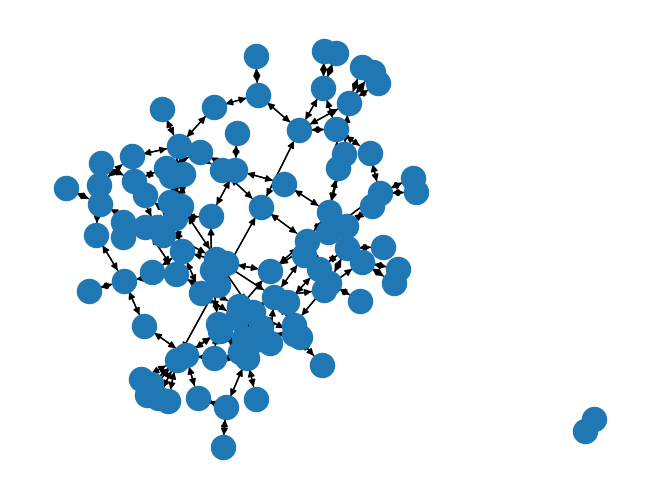

In [673]:
graph = G_dense
nx.draw(G_dense,
        # with_labels=True
        )

## build the matrix

In [621]:
nodes = list(graph.nodes())
link_to_id = {title:id for id,title in enumerate(nodes)}
id_to_link = {id:title for id,title in enumerate(nodes)}

In [622]:
num_nodes = graph.number_of_nodes()
M = torch.zeros(num_nodes, num_nodes)

for src_node in graph:
    src_id = link_to_id[src_node]
    # print(src_node)
    for dest_node in graph[src_node]:
        dest_id = link_to_id[dest_node]
        M[dest_id][src_id] = 1.

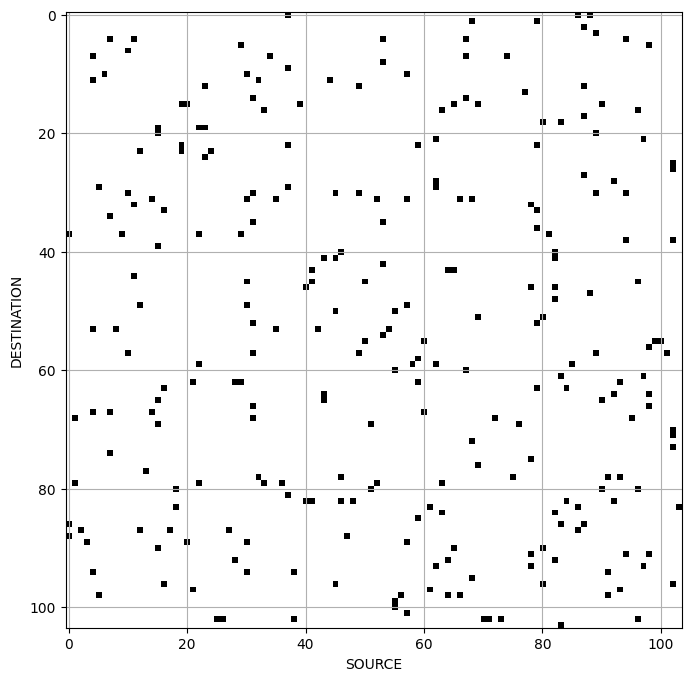

In [623]:
fig,ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(M, cmap = "binary")
ax.set_xlabel("SOURCE")
ax.set_ylabel("DESTINATION")
ax.grid(True, which = "both")
plt.show()

### ripasso matrici pytorch

In [587]:
A = torch.tensor([[0,2,3],[0,2,6]])
col_sums = A.sum(dim = 0)
col_sums[col_sums == 0] = 1

A/col_sums


# dim tells PyTorch which axis to collapse when reducing (sum, mean, max, etc).
#   dim=0: collapse rows → you get something per column.
#   dim=1: collapse columns → you get something per row.

# So the dimension you choose disappears (collapses), and the other one stays.

tensor([[0.0000, 0.5000, 0.3333],
        [0.0000, 0.5000, 0.6667]])

In [588]:
A.sum(dim = 0)

tensor([0, 4, 9])

In [589]:
A[1][2] # row and column


tensor(6)

In [590]:
A.shape

torch.Size([2, 3])

In [591]:
A

tensor([[0, 2, 3],
        [0, 2, 6]])

In [592]:
A[1][2]

tensor(6)

## interpretazione matrice

In [624]:
col_sums = M.sum(dim=0)
col_sums[col_sums == 0] = 1 # pages with no outgoing links, pages that have all zeros in the column vectors
normalized = M/col_sums
normalized

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [625]:
normalized.sum(dim = 0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [626]:
normalized[:, 80] # all the rows (destinarions) of a certain column (source)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [627]:
torch.argmax(normalized[29, :]) # all the columns (source) of a certain row (destination)

tensor(5)

In [657]:
def plot_interactive(row, col):
    fig,ax = plt.subplots(1,1, figsize = (6,6))
    col_count = M.sum(dim = 0) # collapse the zeroth dimension, rows
    ax.imshow(M, cmap = "binary")
    ax.set_xlabel("SOURCE")
    ax.set_ylabel("DESTINATION")
    ax.grid(True, which = "both")

    rows = (M[:, col] > 0).nonzero(as_tuple=True)[0]

    for r in rows:
          ax.scatter(col, r.item(), color="red", s=100, marker="x", alpha=1)
          ax.annotate(f"{id_to_link[r.item()]}", (col-3,r-2), fontsize = 8)
    cols = (M[:, row] > 0).nonzero(as_tuple=True)[0]

    for c in cols:
          ax.scatter(c.item(), row, color="red", s=100, marker="x", alpha=1)
          ax.annotate(f"{id_to_link[c.item()]}", (c-3,row-2), fontsize = 8)
    ax.text(
        0.25, 1.05,  # place below the axis
        f"SOURCE -> {id_to_link[col]}\nDESTINATION -> {id_to_link[row]}\n the column {id_to_link[col]} is the source of -> {int(col_count[col])} links",
        transform=ax.transAxes,
        fontsize=9,
        bbox=dict(facecolor='grey', edgecolor='red', alpha=0.7)
    )
    ax.axhline(y=row)
    ax.axvline(x=col)

interact(plot_interactive,
         row=IntSlider(value=10, min=0, max=graph.number_of_nodes()-1, step=1, description="row (destination)"),
         col=IntSlider(value=10, min=0, max=graph.number_of_nodes()-1, step=1, description="col (source)")
         )


interactive(children=(IntSlider(value=10, description='row (destination)', max=103), IntSlider(value=10, descr…

<function __main__.plot_interactive(row, col)>

In [658]:
link_to_id["Marine biology"]

77

## eigen analysis

### easy

In [598]:
# let's see an easy example

In [599]:
transition_matrix = torch.tensor([[1,0,1],[0,0,1],[1,1,0]], dtype = torch.float32)
transition_matrix

tensor([[1., 0., 1.],
        [0., 0., 1.],
        [1., 1., 0.]])

In [600]:
col_sums = transition_matrix.sum(dim=0)
col_sums[col_sums == 0] = 1 # pages with no outgoing links, pages that have all zeros in the column vectors
normalized = transition_matrix/col_sums
normalized

tensor([[0.5000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.5000],
        [0.5000, 1.0000, 0.0000]])

In [601]:
# the transition matrix can be applyied to any vector, where the vector represents the probability of being in each one of the sites
# this process is a Markov process, it is stationary and infact it always admits a eigenvalue = 1,
# or in other words, when applying the transition matrix to a vector, the vector does not change when lambda = 1:
# Ax = x for lambda = 1
# and by definition the vector x gives us the importance of each website
# when setting lambda = 1 we are literally finding the stationary matrix, a set of x from which we dont move--> applying the transition matrix again, does not affect the probability AKA stationary

In [602]:
x = torch.tensor([1/3, 1/3, 1/3], dtype =torch.float32) # we have a uniform probability of being in any one of the sites
normalized@x


tensor([0.3333, 0.1667, 0.5000])

In [603]:
eigenvalues,eigenvectors = torch.linalg.eig(normalized)

In [604]:
eigenvalues = torch.real(eigenvalues)
eigenvectors = torch.real(eigenvectors)

In [605]:
eigenvectors # let's take the vector that refers to the eigenvalue = 1

tensor([[ 0.3090, -0.8090, -0.6667],
        [ 0.5000,  0.5000, -0.3333],
        [-0.8090,  0.3090, -0.6667]])

In [606]:
lambda_1_eigenvector = eigenvectors[:,torch.round(eigenvalues) == 1] # all rows of the index where the eigenvalue = 1

In [607]:
abs(lambda_1_eigenvector/lambda_1_eigenvector.sum(dim = 0))

tensor([[0.4000],
        [0.2000],
        [0.4000]])

In [608]:
# if we apply the transition matrix multiple times, we get the same result:
x = torch.tensor([1/3, 1/3, 1/3], dtype =torch.float32) # we have a uniform probability of being in any one of the sites


In [609]:
for _ in range(10):
  x = normalized@x
  print(x)

#when the vector stabilize, that is the stationary distribution

tensor([0.3333, 0.1667, 0.5000])
tensor([0.4167, 0.2500, 0.3333])
tensor([0.3750, 0.1667, 0.4583])
tensor([0.4167, 0.2292, 0.3542])
tensor([0.3854, 0.1771, 0.4375])
tensor([0.4115, 0.2188, 0.3698])
tensor([0.3906, 0.1849, 0.4245])
tensor([0.4076, 0.2122, 0.3802])
tensor([0.3939, 0.1901, 0.4160])
tensor([0.4049, 0.2080, 0.3870])


### apply to real data

In [629]:
col_sums = M.sum(dim=0)
col_sums[col_sums == 0] = 1 # pages with no outgoing links, pages that have all zeros in the column vectors
normalized = M/col_sums
normalized

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [630]:
eigenvalues,eigenvectors = torch.linalg.eig(normalized)

In [631]:
real_eigenvalues = torch.real(eigenvalues)
real_eigenvectors = torch.real(eigenvectors)

In [632]:
idx = torch.argmin(torch.abs(real_eigenvalues - 1))  # index of eigenvalue closest to 1
lambda_1_eigenvector = eigenvectors[:, idx].real


In [633]:
lambda_1_eigenvector

tensor([-0.0040, -0.0027, -0.0013, -0.0013, -0.0067, -0.0027, -0.0013, -0.0053,
        -0.0013, -0.0013, -0.0040, -0.0040, -0.0040,  0.7065, -0.0027, -0.0080,
        -0.0040, -0.0013, -0.0027, -0.0040, -0.0027, -0.0027, -0.0053, -0.0040,
        -0.0013, -0.0013, -0.0013, -0.0013, -0.0027, -0.0040, -0.0080, -0.0093,
        -0.0027, -0.0027, -0.0013, -0.0027, -0.0013, -0.0067, -0.0027, -0.0013,
        -0.0027, -0.0040, -0.0013, -0.0040, -0.0013, -0.0053, -0.0040, -0.0013,
        -0.0013, -0.0040, -0.0027, -0.0027, -0.0027, -0.0067, -0.0013, -0.0053,
        -0.0013, -0.0067, -0.0013, -0.0053, -0.0027, -0.0027, -0.0067, -0.0040,
        -0.0040, -0.0040, -0.0027, -0.0053, -0.0053, -0.0040, -0.0013, -0.0013,
        -0.0013, -0.0013, -0.0013, -0.0013, -0.0013,  0.7065, -0.0067, -0.0080,
        -0.0053, -0.0013, -0.0080, -0.0053, -0.0027, -0.0013, -0.0040, -0.0067,
        -0.0027, -0.0053, -0.0040, -0.0040, -0.0040, -0.0040, -0.0053, -0.0013,
        -0.0053, -0.0040, -0.0067, -0.00

In [634]:
importance = abs(lambda_1_eigenvector/lambda_1_eigenvector.sum(dim = 0))

In [635]:
torch.argmax(importance).item()

13

In [636]:
id_to_link[torch.argmax(importance).item()]

'Surface tension'

In [576]:
# That page is the one where a random web surfer is most likely to end up after many clicks.
# In PageRank terms, it’s the most “important” page in your network because many other pages
# point to it (directly or indirectly), or because it sits at the center of good link paths.

## damping

P′=αP+(1−α)n1​J

In [677]:
col_sums = M.sum(dim=0)
col_sums[col_sums == 0] = 1
normalized = M/col_sums
normalized

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [678]:
n = normalized.size(0)
alpha = 0.85

J = torch.ones((n, n)) / n
damped = alpha * normalized + (1 - alpha) * J
# with damping we are modelling the possibility that the user have a low but still NOT zero probability of going from one site to any other site

In [679]:
eigenvalues,eigenvectors = torch.linalg.eig(damped)
real_eigenvalues = torch.real(eigenvalues)
real_eigenvectors = torch.real(eigenvectors)

In [680]:
idx = torch.argmin(torch.abs(real_eigenvalues - 1))  # index of eigenvalue closest to 1
lambda_1_eigenvector = eigenvectors[:, idx].real


In [681]:
lambda_1_eigenvector

tensor([-0.1066, -0.0681, -0.0440, -0.0390, -0.1541, -0.0655, -0.0402, -0.1380,
        -0.0434, -0.0413, -0.0959, -0.1046, -0.0988, -0.0867, -0.0642, -0.1794,
        -0.0923, -0.0440, -0.0678, -0.0938, -0.0644, -0.0658, -0.1223, -0.1036,
        -0.0424, -0.0439, -0.0439, -0.0440, -0.0641, -0.0946, -0.1656, -0.2009,
        -0.0685, -0.0648, -0.0423, -0.0678, -0.0387, -0.1661, -0.0689, -0.0384,
        -0.0636, -0.0877, -0.0434, -0.0883, -0.0426, -0.1164, -0.0908, -0.0491,
        -0.0379, -0.0897, -0.0693, -0.0682, -0.0631, -0.1786, -0.0434, -0.1486,
        -0.0387, -0.1485, -0.0418, -0.1356, -0.0714, -0.0692, -0.1498, -0.0920,
        -0.0894, -0.0888, -0.0631, -0.1262, -0.1385, -0.1034, -0.0439, -0.0439,
        -0.0424, -0.0439, -0.0423, -0.0389, -0.0423, -0.0867, -0.1523, -0.1813,
        -0.1218, -0.0413, -0.1757, -0.1362, -0.0640, -0.0418, -0.1032, -0.1826,
        -0.0850, -0.1222, -0.0895, -0.0895, -0.0905, -0.0917, -0.1173, -0.0424,
        -0.1207, -0.0964, -0.1513, -0.04

In [682]:
importance = abs(lambda_1_eigenvector/lambda_1_eigenvector.sum(dim = 0))

In [683]:
torch.argmax(importance).item()

102

In [684]:
id_to_link[torch.argmax(importance).item()]

'Evolutionary biology'